# Airline Staisfaction Prediction Modeling

## Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, roc_curve, auc
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [3]:
pd.set_option('display.max_columns', None)
sns.set_style('dark')

plt.rcParams['figure.figsize'] = [10, 6]

## Data Import

In [4]:
df = pd.read_csv('./data/cleaned_airline.csv')
# imports cleaned dataset

In [5]:
df.head()
# outputs first 5 rows of data

,id,gender,customer_type,age,type_of_travel,flight_distance,inflight_wifi_service,departure_arrival_time_convenient,ease_of_online_booking,gate_location,food_and_drink,online_boarding,seat_comfort,inflight_entertainment,on_board_service,leg_room_service,baggage_handling,checkin_service,inflight_service,cleanliness,departure_delay_in_minutes,arrival_delay_in_minutes,satisfaction,arrival_delayed_missing,class_codes
0,70172,Male,Loyal Customer,13,Personal Travel,460,3,4,3,1,5,3,5,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied,0,2
1,5047,Male,disloyal Customer,25,Business travel,235,3,2,3,3,1,3,1,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied,0,0
2,110028,Female,Loyal Customer,26,Business travel,1142,2,2,2,2,5,5,5,5,4,3,4,4,4,5,0,0.0,satisfied,0,0
3,24026,Female,Loyal Customer,25,Business travel,562,2,5,5,5,2,2,2,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied,0,0
4,119299,Male,Loyal Customer,61,Business travel,214,3,3,3,3,4,5,5,3,3,4,4,3,3,3,0,0.0,satisfied,0,0


In [6]:
df = df.drop(columns=['id'])
# drops id column, as it is not needed 

## Feature Selection and Splitting

In [7]:
X = df.drop(columns=['satisfaction']) # uses all columns except satisfaction, as this is the target variable
y = df['satisfaction'] # target variable 

In [8]:
num_cols = ['age',
 'flight_distance',
 'departure_delay_in_minutes',
 'arrival_delay_in_minutes']
# columns to scale

cat_cols = ['gender', 'customer_type', 'type_of_travel']
# columns to one-hot encode

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
# splits data into training and testing data with a 70/30 split

In [10]:
y_test_int = y_test.map({'neutral or dissatisfied': 0, 'satisfied': 1}) 
# creates a series of 1s and 0s for roc curve of the satisfaction column 

In [11]:
def make_preprocessor():
    """
    Creator: Daniel Gallo
    Inputs: None
    Outputs: a column transformer that scales the numerical columns, and one hot encodes the category columns 
    """
    preprocessor = ColumnTransformer(
        transformers=[
            ('scale', StandardScaler(), num_cols),
            ('one', OneHotEncoder(handle_unknown='ignore'), cat_cols)
        ], remainder='passthrough'
    )

    return preprocessor

## Modeling

### Logistic Regression

In [12]:
pipeline_logreg = Pipeline(
    steps=[
        ('preprocess', make_preprocessor()),
        ('model', LogisticRegression())
    ]
)
# creates a pipeline for logistic regression 

In [13]:
pipeline_logreg.fit(X_train, y_train)
# fits the model

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scale', ...), ('one', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transfor

In [14]:
pipeline_logreg.score(X_test, y_test)
# gets the accuracy score of the model 

0.8753689208263826

In [15]:
logred_preds = pipeline_logreg.predict(X_test)
# gets the predictions of the X_test set

In [16]:
print(classification_report(y_test, logred_preds))
# outputs the classification report of the model. 

                         precision    recall  f1-score   support

neutral or dissatisfied       0.88      0.91      0.89     17664
              satisfied       0.87      0.83      0.85     13508

               accuracy                           0.88     31172
              macro avg       0.87      0.87      0.87     31172
           weighted avg       0.88      0.88      0.88     31172



> This classification report tells us that the model did very well.
>
> When the model predicts dissatisfied, it gets it right 88% of the time, and when it predicts satisfied, it is right 87% of the time
>
> It was also able to find 91% and 83% of all dissatsified and satisfied customers respecivly.
> 

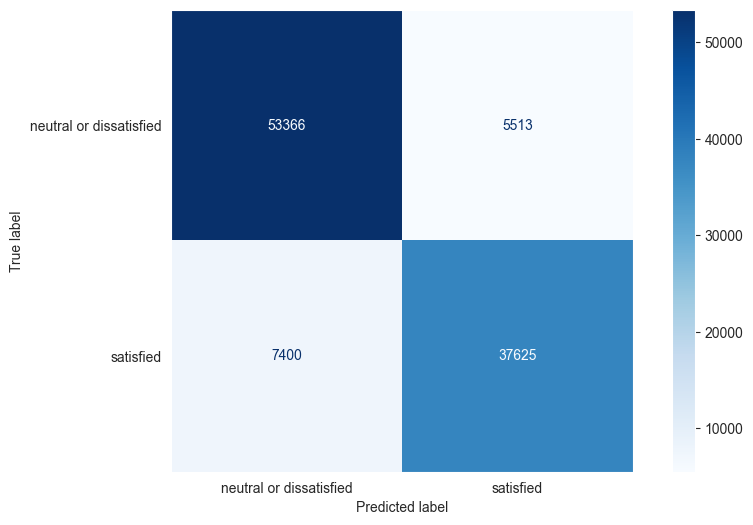

In [17]:

ConfusionMatrixDisplay.from_estimator(pipeline_logreg, X, y, cmap='Blues')
plt.savefig('./images/logreg_conf.png')
# creats a confusion matrix of the model's prediction for the entire dataset (X and y)

> The above confusion matrix tells us that the model correctly predicted 53366 dissatisfied passengers, and 37625 staisfied customers.
>
> However, it incorrectly predicted 5513 dissatisfied passengers as satisfied, and 7400 satisfied passengers as dissatisfied.

In [18]:
logreg_probs = pipeline_logreg.predict_proba(X_test)[:, 1]
# returns the probabilities of the predictions of X_test

roc_auc = roc_auc_score(y_test, logreg_probs)
roc_auc
# gets the roc_auc score of the prediction probabities 

0.9272880731171651

> The model got a 0.93 roc auc score, which means that there is a 93% chance that the model ranks a randomly chosen positive example higher than a randomly chosen negative example.
>
> This means that the model was able to separate the two classes (satisfied and dissatisfied) very well. 

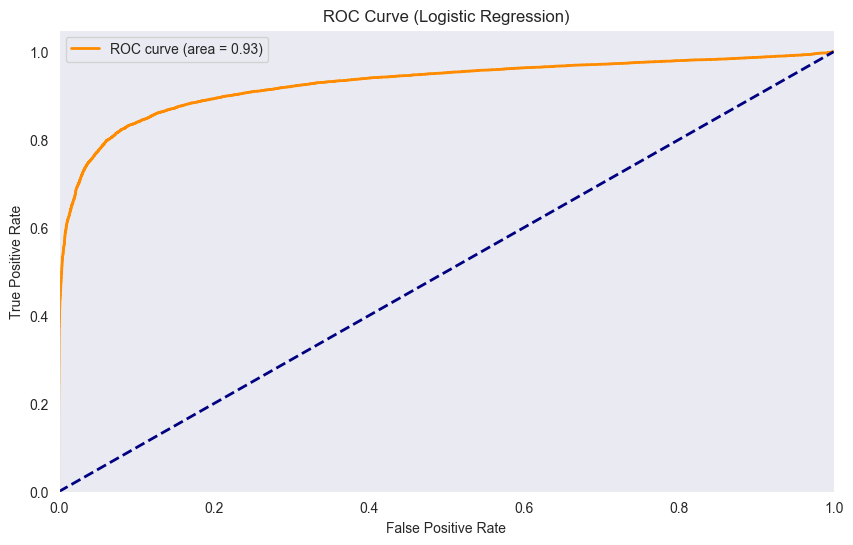

In [19]:
fpr, tpr, thresh = roc_curve(y_test_int, logreg_probs)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()
plt.title("ROC Curve (Logistic Regression)")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('./images/logreg_roc.png')

> This ROC curve shows that the model separates the classes very well, as indicated by the steep rise near the y-axis. This means the model achieves a high true positive rate while maintaining a low false positive rate across a range of thresholds

### Random Forest

In [23]:
pipeline_rf = Pipeline(
    steps=[
        ('preprocess', make_preprocessor()),
        ('model', RandomForestClassifier(random_state=42))
    ]
)
# creates the random forest pipeline 

In [24]:
pipeline_rf.fit(X_train, y_train)
# fits the model 

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('preprocess', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"transformers transformers: list of tuplesList of (name, transformer, columns) tuples specifying thetransformer objects to be applied to subsets of the data.name : str Like in Pipeline and FeatureUnion, this allows the transformer and its parameters to be set using ``set_params`` and searched in grid search.transformer : {'drop', 'passthrough'} or estimator Estimator must support :term:`fit` and :term:`transform`. Special-cased strings 'drop' and 'passthrough' are accepted as well, to indicate to drop the columns or to pass them through untransformed, respectively.columns : str, array-like of str, int, array-like of int, array-like of bool, slice or callable Indexes the data on its second axis. Integers are interpreted as positional columns, while strings can reference DataFrame columns by name. A scalar string or int should be used where ``transformer`` expects X to be a 1d array-like (vector), otherwise a 2d array will be passed to the transformer. A callable is passed the input data `X` and can return any of the above. To select multiple columns by name or dtype, you can use :obj:`make_column_selector`.","[('scale', ...), ('one', ...)]"
,"remainder remainder: {'drop', 'passthrough'} or estimator, default='drop'By default, only the specified columns in `transformers` aretransformed and combined in the output, and the non-specifiedcolumns are dropped. (default of ``'drop'``).By specifying ``remainder='passthrough'``, all remaining columns thatwere not specified in `transformers`, but present in the data passedto `fit` will be automatically passed through. This subset of columnsis concatenated with the output of the transformers. For dataframes,extra columns not seen during `fit` will be excluded from the outputof `transform`.By setting ``remainder`` to be an estimator, the remainingnon-specified columns will use the ``remainder`` estimator. Theestimator must support :term:`fit` and :term:`transform`.Note that using this feature requires that the DataFrame columnsinput at :term:`fit` and :term:`transform` have identical order.",'passthrough'
,"sparse_threshold sparse_threshold: float, default=0.3If the output of the different transfor

In [25]:
pipeline_rf.score(X_test, y_test)
# gets the accuracy score of the model

0.9605735916848454

In [26]:
rf_preds = pipeline_rf.predict(X_test)
# generates predictions for the X_test set

In [27]:
print(classification_report(y_test, rf_preds))
# prints classification report of the model's predictions 

                         precision    recall  f1-score   support

neutral or dissatisfied       0.95      0.98      0.97     17664
              satisfied       0.97      0.94      0.95     13508

               accuracy                           0.96     31172
              macro avg       0.96      0.96      0.96     31172
           weighted avg       0.96      0.96      0.96     31172



> We can see with this classification report, the random forest model did much better than the losistic regression model.
>
> It was able to get above 0.9 for both percision and recall for both classes. 

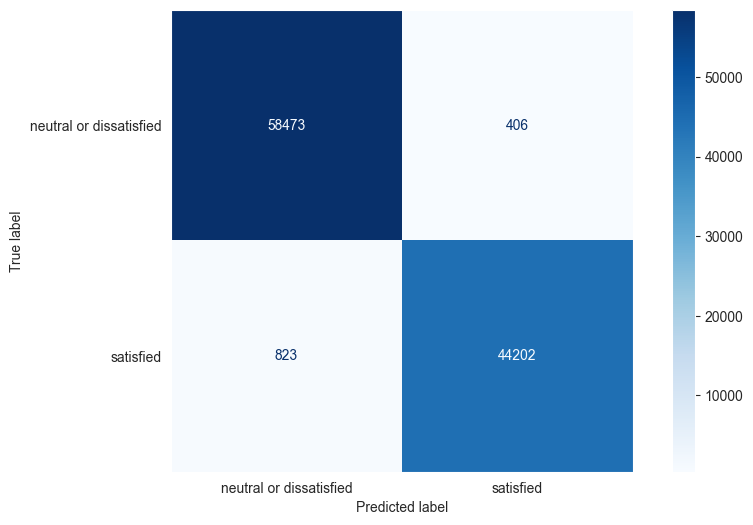

In [28]:
ConfusionMatrixDisplay.from_estimator(pipeline_rf, X, y, cmap='Blues')
plt.savefig('./images/rf_conf.png')
# creates confusion matrix of the model 

> We can see that the random forest model also has a better confusion matrix, getting less than 1000 wrong predictions in either satisfied or dissatsified classfiications 

In [29]:
rf_probs = pipeline_rf.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, rf_probs)
roc_auc
# gets the roc score of random forest

0.9933366068564308

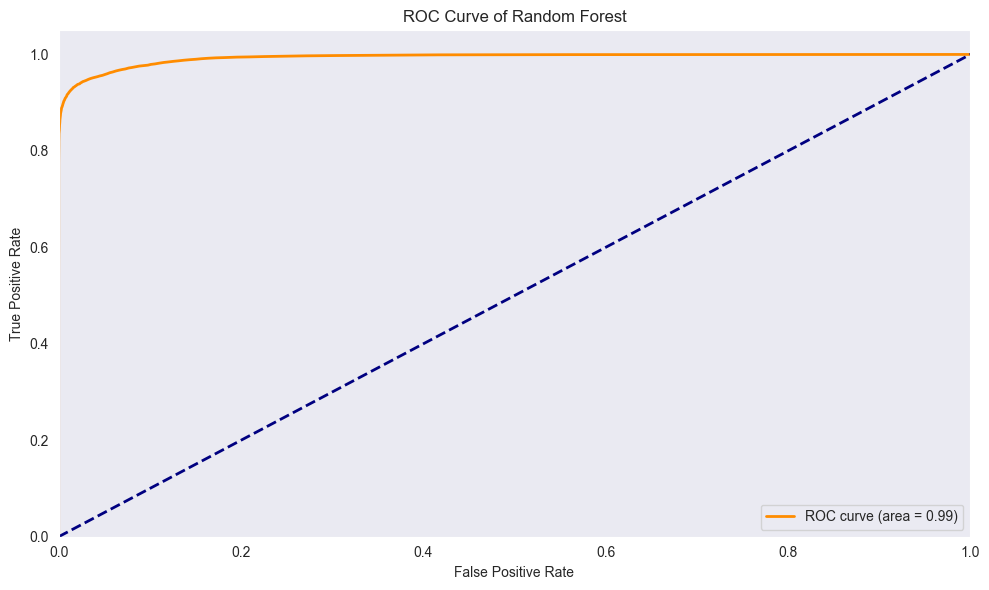

In [30]:
fpr, tpr, thresh = roc_curve(y_test_int, rf_probs)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title("ROC Curve of Random Forest")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.tight_layout()
plt.savefig('./images/rf_roc.png')

> This plot shows the ROC Curve of the Random Forest model. The score it acheives is 0.99, which means that 99% of the time, it will rank a random positive higher than a random negative. There is  threshold where the True Positive Rate is very high, while the False Positive Rate is very low.
>
> In simpler terms, this model has a very good separation between positives and negatives, so it can accurately tell the difference between a positive and a negative. 

### K Nearest Neighbors

In [31]:
pipeline_knn = Pipeline(
    steps=[
        ('preprocess', make_preprocessor()),
        ('model', KNeighborsClassifier())
    ]
)
# creates a knn pipeline

In [32]:
param_grid = {
    'model__n_neighbors': np.arange(3, 31, 2),
    'model__weights': ['uniform', 'distance']
}
# param grid for the knn model

In [33]:
grid_pipe = GridSearchCV(pipeline_knn, param_grid, cv=5)
# creates a grid search cv to test different parameters of the model. 

In [34]:
grid_pipe.fit(X_train, y_train)
# fits the model

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...lassifier())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'model__n_neighbors': array([ 3, 5..., 25, 27, 29]), 'model__weights': ['uniform', 'distance']}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",None
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;-

In [35]:
grid_pipe.score(X_test, y_test)
# gets the best accuracy score of the model

0.9279802386757346

In [36]:
grid_pipe.best_params_
# gets the best parameters tested with

{'model__n_neighbors': np.int64(9), 'model__weights': 'distance'}

In [37]:
knn_preds = grid_pipe.predict(X_test)
# generates predictions of the knn model

In [38]:
print(classification_report(y_test, knn_preds))
# prints the calssification report of the model

                         precision    recall  f1-score   support

neutral or dissatisfied       0.92      0.96      0.94     17664
              satisfied       0.94      0.89      0.91     13508

               accuracy                           0.93     31172
              macro avg       0.93      0.92      0.93     31172
           weighted avg       0.93      0.93      0.93     31172



> The KNN model did better than the logisitc model, but not as good as random forest. 

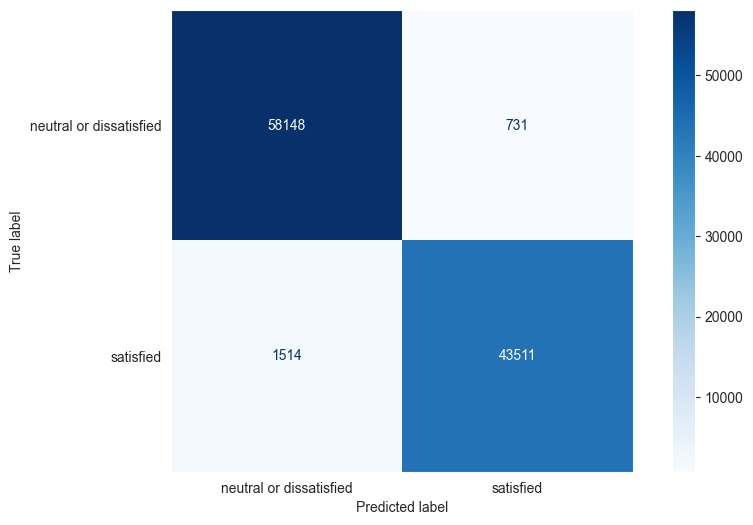

In [39]:
ConfusionMatrixDisplay.from_estimator(grid_pipe.best_estimator_, X, y, cmap='Blues')
plt.savefig('./images/knn_conf.png')
# creates a confusion matrix of the knn model 

> This further shows that the model did better than logistic regression, but not as well as random forest. 

In [40]:
knn_probs = grid_pipe.predict_proba(X_test)[:, 1]


roc_auc = roc_auc_score(y_test, knn_probs)
roc_auc
# generates the roc score for knn

0.9766119708181519

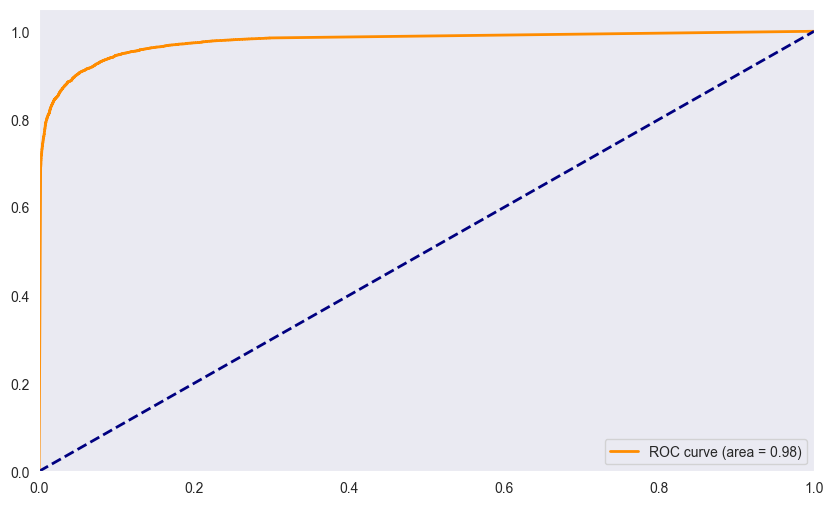

In [41]:
fpr, tpr, thresh = roc_curve(y_test_int, knn_probs)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend()
plt.savefig('./images/knn_roc.png')

> This roc curve also shows that the knn model did very well at separating the two classes. 

## Saving Models

In [42]:
import joblib

In [43]:
joblib.dump(pipeline_logreg, './models/logreg.pkl')
# saves the losgistic regression model in a pkl file. 

['./models/logreg.pkl']

In [44]:
joblib.dump(pipeline_rf, './models/rf.pkl')
# saves the random forest model in a pkl file. 

['./models/rf.pkl']

In [45]:
joblib.dump(grid_pipe, './models/knn.pkl')
# saves the k nearest neighbors model in a pkl file. 

['./models/knn.pkl']